In [ ]:
# 2) load your Parquet
import pandas as pd
parquet_path = r"C:/Projects/clasificador_mensajes_Copy - Copy/data/experiments/exp_mix_20250930T022031Z__atlas_2d.parquet"
df = pd.read_parquet(parquet_path)

# 3) launch the Embedding Atlas widget (uses your 2D columns)
from embedding_atlas.widget import EmbeddingAtlasWidget

widget = EmbeddingAtlasWidget(
    df,
    text="text",      # tooltip/search text column
    x="e0",           # X coordinate column
    y="e1",           # Y coordinate column
    labels="automatic",
    show_table=True,
    show_charts=True,
    show_embedding=True,
)

df.head()
widget  # ← display inline


In [14]:
import pandas as pd
import numpy as np

print(df.shape)
print(df.dtypes[['e0','e1','text']])

# Must be finite numeric columns
bad = (~np.isfinite(df['e0'])) | (~np.isfinite(df['e1']))
print("Non-finite coords:", bad.sum())

# If there are NaNs/inf, drop them for a quick test:
df_ok = df[['e0','e1','text']].copy()
df_ok = df_ok[np.isfinite(df_ok['e0']) & np.isfinite(df_ok['e1'])]
print("After cleaning:", df_ok.shape)
df_ok.head(2)


(27463, 9)
e0      float32
e1      float32
text     object
dtype: object
Non-finite coords: 0
After cleaning: (27463, 3)


,e0,e1,text
0,-6.272159,-0.672664,lets do a debugger of the parser--- in ipynb n...
1,-6.264522,-0.664268,lets do a debugger of the parser--- give me ce...


In [16]:
# Verify widgets installed & active
import ipywidgets as iw
print("ipywidgets:", iw.__version__)

# In classic Notebook you may need this once (then restart kernel):
# !jupyter nbextension enable --py widgetsnbextension

# In JupyterLab ≥4 or VS Code, ipywidgets is usually built-in;
# if not, `pip install ipywidgets` and restart the kernel.


ipywidgets: 8.1.5


In [17]:
from IPython.display import display
from embedding_atlas.widget import EmbeddingAtlasWidget

w = EmbeddingAtlasWidget(
    df_ok,                 # use the cleaned df for now
    text="text",
    x="e0",
    y="e1",
    height=600,            # give it space (some envs render 0px otherwise)
    show_table=True,       # optional, to confirm UI renders
    show_charts=True,
    show_embedding=True,
)
display(w)


ValueError: The following options are not allowed for the Embedding Atlas widget: height. Allowed options are labels, stop_words, table, show_table, neighbors, show_charts, y, show_embedding, text, point_size, row_id, x

In [20]:
# --- 0) Imports
import pandas as pd, numpy as np
from embedding_atlas.widget import EmbeddingAtlasWidget
from IPython.display import display

# --- 1) Load your parquet
parquet_path = r"C:/Projects/clasificador_mensajes_Copy - Copy/data/experiments/exp_mix_20250930T022031Z__atlas_2d.parquet"
df = pd.read_parquet(parquet_path)

# --- 2) Verify the required columns exist and are usable
required = ["e0","e1","text"]
print("Columns present:", set(required).issubset(df.columns), " -> ", required)
print(df[required].dtypes)

# Coerce to numeric & drop non-finite coords
df = df.copy()
df["e0"] = pd.to_numeric(df["e0"], errors="coerce")
df["e1"] = pd.to_numeric(df["e1"], errors="coerce")
df["text"] = df["text"].astype(str)

mask = np.isfinite(df["e0"]) & np.isfinite(df["e1"])
print("Finite coords:", mask.sum(), "/", len(df))
df_ok = df.loc[mask, ["e0","e1","text"]].reset_index(drop=True)

# Quick peek of ranges so we know it's not all zeros/NaN
print("e0 range:", df_ok["e0"].min(), "→", df_ok["e0"].max())
print("e1 range:", df_ok["e1"].min(), "→", df_ok["e1"].max())

# --- 3) Try a tiny sample first (to rule out rendering perf issues)
df_small = df_ok.sample(min(2000, len(df_ok)), random_state=0).copy()
print("Sample size:", len(df_small))

w = EmbeddingAtlasWidget(
    df_small,
    x="e0",
    y="e1",
    text="text",
    show_embedding=True,
    show_table=True,
    show_charts=True,
    labels="automatic",
    point_size=3,   # a bit larger to make them visible
)
display(w)


Columns present: True  ->  ['e0', 'e1', 'text']
e0      float32
e1      float32
text     object
dtype: object
Finite coords: 27463 / 27463
e0 range: -16.712542 → 21.193832
e1 range: -12.15813 → 22.639435
Sample size: 2000


EmbeddingAtlasWidget()

In [21]:
import pandas as pd, numpy as np
from embedding_atlas.widget import EmbeddingAtlasWidget
from IPython.display import display

# Load your parquet
parquet_path = r"C:/Projects/clasificador_mensajes_Copy - Copy/data/experiments/exp_mix_20250930T022031Z__atlas_2d.parquet"
df = pd.read_parquet(parquet_path).copy()

# Ensure required columns exist & are clean
for c in ("e0","e1"):
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df[np.isfinite(df["e0"]) & np.isfinite(df["e1"])]
df["text"] = df["text"].astype(str)

# Give the widget a unique row id & a table name (helps its DuckDB backend)
row_id_col = "message_id" if "message_id" in df.columns else "_row_id"
if row_id_col not in df.columns:
    df[row_id_col] = np.arange(len(df), dtype=np.int64)

# (Sometimes bounds detection glitches.) Normalize to [0,1] to be safe:
def minmax(s):
    mn, mx = float(s.min()), float(s.max())
    return (s - mn) / (mx - mn) if mx > mn else s * 0.0
df["_x"] = minmax(df["e0"])
df["_y"] = minmax(df["e1"])

# Try a small sample first (to rule out rendering perf issues)
df_view = df.sample(min(5000, len(df)), random_state=0).copy()

w = EmbeddingAtlasWidget(
    df_view,
    x="_x",
    y="_y",
    text="text",
    row_id=row_id_col,
    table="atlas_df",
    show_embedding=True,
    show_table=True,
    show_charts=True,
    labels="automatic",
    point_size=3,          # make points visible
)
display(w)


EmbeddingAtlasWidget()

In [22]:
# Test ipywidgets plumbing
import ipywidgets as widgets
widgets.IntSlider(description="Works?")


IntSlider(value=0, description='Works?')

In [23]:
# Test Altair/Vega rendering (Embedding Atlas relies on this stack)
import pandas as pd, numpy as np, altair as alt
df_test = pd.DataFrame({"e0": np.random.randn(500), "e1": np.random.randn(500)})
alt.Chart(df_test).mark_circle(size=30).encode(x="e0", y="e1")


alt.Chart(...)

In [24]:
!pip install -q ipywidgets altair duckdb vegafusion vegafusion-python-embed vegafusion-jupyter embedding-atlas pandas pyarrow


In [25]:
import pandas as pd, numpy as np
from embedding_atlas.widget import EmbeddingAtlasWidget
from IPython.display import display

df = pd.read_parquet(r"C:/Projects/clasificador_mensajes_Copy - Copy/data/experiments/exp_mix_20250930T022031Z__atlas_2d.parquet").copy()

# coerce + clean
df["e0"] = pd.to_numeric(df["e0"], errors="coerce")
df["e1"] = pd.to_numeric(df["e1"], errors="coerce")
df = df[np.isfinite(df["e0"]) & np.isfinite(df["e1"])]
df["text"] = df["text"].astype(str)

# ensure a unique row id (use message_id if you kept it)
row_id_col = "message_id" if "message_id" in df.columns else "_row_id"
if row_id_col not in df.columns:
    df[row_id_col] = np.arange(len(df), dtype=np.int64)

w = EmbeddingAtlasWidget(
    df,
    x="e0",
    y="e1",
    text="text",
    row_id=row_id_col,
    table="atlas_df",
    show_embedding=True,
    show_table=True,
    show_charts=True,
    labels="automatic",
    point_size=3
)
display(w)


EmbeddingAtlasWidget()

In [ ]:
import altair as alt
import pandas as pd, numpy as np

df = pd.DataFrame({"x": np.random.randn(500), "y": np.random.randn(500)})
alt.Chart(df).mark_circle(size=30).encode(x="x", y="y")


In [ ]:
import sys, subprocess, site, os

print("Python:", sys.executable)
print("site-packages:", site.getsitepackages())

# Install into THIS interpreter
pkgs = [
    "altair==5.*",
    "ipywidgets",
    "duckdb",
    "vegafusion",
    "vegafusion-python-embed",
    "vegafusion-jupyter",
    "pandas",
    "pyarrow",
]
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U"] + pkgs)

# Verify install
import importlib, pkgutil
print("Altair installed?", pkgutil.find_loader("altair") is not None)


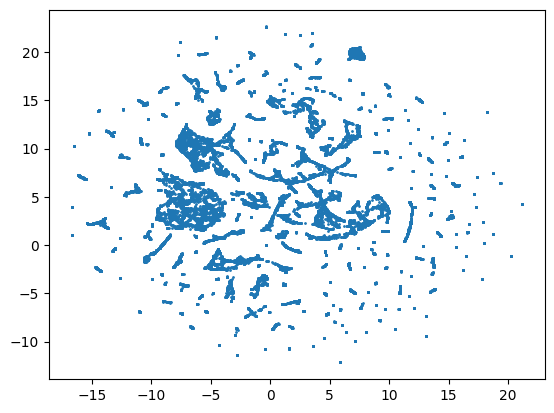

In [26]:
import matplotlib.pyplot as plt
plt.scatter(df["e0"], df["e1"], s=1); plt.show()
